# Nano indenter
v2: Add a file path to the output folder, so modified data ends up in the process folder

v6: Add error_model="poisson" to the integrate1d keyword arguments.
    Modify data output. q, int, sigma are always are saved for each calculation.
    
v6 2019052208: A notebook for the second commissioning and TiAlN as deposited, 1000C TiAlN     

In [ ]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import h5py
import time as t
import pyFAI as pyFAI
print(pyFAI.__file__)
print(pyFAI.version)

from pyFAI.gui import jupyter
import fabio as fabio
import os as os
import copy

from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator, FormatStrFormatter


from time import time
import datetime
# Bokeh might to try to load some javascript and that causes problems
#try out a new library
#from bokeh.io import output_file, show, output_notebook
#from bokeh.plotting import figure

In [ ]:
# Class definition
class PilatusData:
    def __init__(self, data_input_file, output_path, poni_file=None, mask_file=None):
        """ Creation of PilatusData class """
        # Store locals
        self.data_input_file = data_input_file
        # set output_path and remove trailing backslash
        self.output_path = os.path.normpath(output_path)
        self.mask = mask_file
        if self.mask:
            self.mask_data = fabio.open(self.mask).data
        self.poni = poni_file
        if self.poni:
            # This integrator uses ChiDiscAtPi (standard)
            self.aipi = pyFAI.load(self.poni)
            
            # Create the second-integrator with ChiDiscAtZero. 
            self.ai0 = copy.deepcopy(self.aipi)
            self.ai0.setChiDiscAtZero()
            
            
        # Separate file path from file name
        self.filepath_input_file, self.filename = os.path.split(data_input_file)
        # Open the file and store number of data entries
        with h5py.File(self.data_input_file, 'r') as hf:
            self.data_keys = list(hf.keys())
            self.total_number_entries = len(self.data_keys)
        # Check that data file exist
        with h5py.File(self.data_input_file, 'r'):
            pass
        # self.file_reader = file_reader(self.data_input_file)

    def data_read(self, entry_number):
        """ Open file and read data """
        
        # verify if entry_number is an integer:
        if not isinstance(entry_number,int):
            raise TypeError('entry_number must be an integer value.')  
            
        # confirm if given entry_number is in range
        if not entry_number in range(0,self.total_number_entries):
            raise ValueError("entry_number out of range.")    
        
        with h5py.File(self.data_input_file, 'r') as file_reader:
            return self._data_read(file_reader, entry_number)

    def _data_read(self, file_reader, entry_number):
        """ Read data from an open file """
        # returns one detector image
        h5data = file_reader.get(self.data_keys[entry_number] + '/measurement/Pilatus/data')
        return np.squeeze(np.array(h5data))

    def split_filename_extension(self, filename):
        """ Read data from an open file """
        filename_no_ext, _ = os.path.splitext(filename)
        return filename_no_ext

    def data_sum_up_all(self, generate_calibration2d_file=False):
        """ Sum all data up into one numpy array """

        # Allocate some space
        with h5py.File(self.data_input_file, 'r') as file_reader:
            pilatusdata_sum = self._data_read(file_reader, 0)
            for i in range(1, self.total_number_entries):
                pilatusdata_sum += self._data_read(file_reader, i)
            if generate_calibration2d_file:
                filename_no_ext = self.split_filename_extension(self.filename)
                print(filename_no_ext)
                output_name = os.path.join(self.output_path,filename_no_ext + "_summed.npy")
                print(output_name)
                np.save(output_name, pilatusdata_sum)
        return pilatusdata_sum


    def data_integrate1d(self, pilatusdata, output_name=None, radial_range=None, azimuth_range=None, **kwargs):
        """ This function generates 1d integrated data.
            Input arguments:
            pilatusdata: A numpy array
            radial_range: select q-range
            azimuth_range: select azimuthal angle
            output_name: select a name for the output file #check for output path?

            Output:
            Returns: q/2th/r bins center positions and regrouped intensity (and error array if variance or variance model provided), uneless all==True.
            Return type: Integrate1dResult, dict
        """
        if not self.poni:
            raise ValueError("No poni file is defined, integration is impossible")
        if not self.mask:
            raise ValueError("No mask file is defined, integration is impossible")

            
        # Perform integrate1d
        if azimuth_range is not None:
                   
            chimin, chimax = azimuth_range
                
            if (chimin < 180 and chimax > 180):
                #print('data_integrate1d with chi: ', chimin,chimax)
                
                # Use in this case the integrator with ChiDiscAtZero
                res = self.ai0.integrate1d(
                    data=pilatusdata,
                    npt=1800,
                    filename=output_name,
                    unit="q_A^-1",  # unit="q_nm^-1",  #unit="2th_deg",
                    radial_range=radial_range,
                    azimuth_range=azimuth_range,
                    mask=self.mask_data,
                    correctSolidAngle=True,
                    error_model="poisson",
                    **kwargs)

            else:
                               
                # Use integrator with ChiDiscAtPi
                res = self.aipi.integrate1d(
                    data=pilatusdata,
                    npt=1800,
                    filename=output_name,
                    unit="q_A^-1",  # unit="q_nm^-1",  #unit="2th_deg",
                    radial_range=radial_range,
                    azimuth_range=azimuth_range,
                    mask=self.mask_data,
                    correctSolidAngle=True,
                    error_model="poisson",
                    **kwargs)
       
        else:
            #print('data_integrate1d with: ',azimuth_range)
            
            # Integration in the case for azimuth_range=None with ChiDiscAtPi
            
            res = self.aipi.integrate1d(
                data=pilatusdata,
                npt=1800,
                filename=output_name,
                unit="q_A^-1",  # unit="q_nm^-1",  #unit="2th_deg",
                radial_range=radial_range,
                azimuth_range=azimuth_range,
                mask=self.mask_data,
                correctSolidAngle=True,
                error_model="poisson",
                **kwargs)
            
        return res
        

    def data_integrate2d(self, pilatusdata, npt_rad, output_name=None, radial_range=None, azimuth_range=None, **kwargs):
        """ Calculate the azimuthal regrouped 2d image in q(nm^-1)/chi(deg) by default"""
        if not self.poni:
            raise ValueError("No poni file is defined, integration is impossible")
        if not self.mask:
            raise ValueError("No mask file is defined, integration is impossible")
        if not npt_rad:
            raise ValueError("Provide number of points in the radial direction")

        # Perform integrate2d
        return self.aipi.integrate2d(
            data=pilatusdata,
            npt_rad=npt_rad,
            npt_azim=3600,
            filename=output_name,
            correctSolidAngle=True,
            error_model="poisson",
            radial_range=radial_range,
            azimuth_range=azimuth_range,
            mask=self.mask_data,
            unit="q_A^-1",
            **kwargs)

    def sum_all_and_integrate1d(self, generate_calibration2d_file=False):
        
        output_filename = os.path.join(self.output_path, self.split_filename_extension(self.filename)+ "_sum_all.dat")
        sum_all = self.data_sum_up_all(generate_calibration2d_file)
        res = self.data_integrate1d(sum_all, output_name=output_filename)

        fig, ax = plt.subplots()
        plt.semilogy(res[0], res[1] / self.total_number_entries)  # I divide by the number of entries
        plt.title(self.data_input_file)  # self.filename
        # plt.xlabel('q (nm$^{-1}$)')
        plt.xlabel('2 theta (degrees)')
        plt.ylabel('Intensity')
        plt.grid(axis='both')

        majorLocator = MultipleLocator(5)
        majorFormatter = FormatStrFormatter('%d')
        minorLocator = MultipleLocator(1)

        ax.xaxis.set_major_locator(majorLocator)
        ax.xaxis.set_major_formatter(majorFormatter)
        ax.xaxis.set_minor_locator(minorLocator)

        # jupyter.plot1d(res)
        plt.show()

    def integrate1d_all(self, radial_range=None, azimuth_range=None, output_name=None, **kwargs):
        with h5py.File(self.data_input_file, 'r') as file_reader:
            return self._integrate1d_all(
                file_reader, 
                radial_range=radial_range, 
                azimuth_range=azimuth_range, 
                output_name=output_name,
                **kwargs)

    def _integrate1d_all(self, file_reader, radial_range=None, azimuth_range=None, output_name=None,**kwargs):

        # create general output filename
        output_filename = self.split_filename_extension(self.filename)
    
        # read the data for the first entry 
        pilatusdata = self._data_read(file_reader, 0)
        # integrate it, but no output should be generated, i.e. don't provide output_name or output_name=None
        res = self.data_integrate1d(pilatusdata, radial_range=radial_range, azimuth_range=azimuth_range, **kwargs)
        
         
        # create HDF file to store integrated data, this version is for fly scanning 
        hdf5filename = None
        hdf5dsetname_q="/entry/integ/q"
        hdf5dsetname = "/entry/integ/data"
        hdf5dsetname_sigma="/entry/integ/sigma"
        
        
        if pilatusdata.ndim == 3:
            # create output hdf5file (rewrite) 
            hdf5filename =  os.path.join(self.output_path,"{}_integ_fly.h5".format(output_filename))
            with h5py.File(hdf5filename, "w") as h5f:
                # save q
                h5f.create_dataset(hdf5dsetname_q, data=res[0])
                
                # create a dataset for the integrated data
                h5f.create_dataset(hdf5dsetname, shape=(self.total_number_entries, pilatusdata.shape[0], res[1].size),
                                   dtype=res[0].dtype,
                                   chunks=(self.total_number_entries, pilatusdata.shape[0], 10),
                                   compression="gzip")
                
        # create HDF file to store integrated data, this version is for a step scanning
        if pilatusdata.ndim == 2:
            
            # create output hdf5file (rewrite)
            hdf5filename =  os.path.join(output_path,"{}_integ_step.h5".format(output_filename))
      
            with h5py.File(hdf5filename, "w") as h5f:
                #save q
                # good to know: as long as the radial_range is not changed, the q-range for various azimuth integrations remains the same.
                #h5f.create_dataset("/entry/integ/q", data=res[0]) 
                # change:
                # create a dataset for the q data  
                h5f.create_dataset(hdf5dsetname_q, shape=(self.total_number_entries, res[0].size),
                                               dtype=res[0].dtype,
                                               chunks=True, compression="gzip")
                

                #create a dataset for the integrated data
                h5f.create_dataset(hdf5dsetname, shape=(self.total_number_entries, res[1].size),
                                               dtype=res[1].dtype,
                                               chunks=True, compression="gzip")
                
                
                #create a dataset for the sigma data
                h5f.create_dataset(hdf5dsetname_sigma, shape=(self.total_number_entries, res[2].size),
                                               dtype=res[2].dtype,
                                               chunks=True, compression="gzip")
                
    
        
        for i in range(0, self.total_number_entries):

            # read in each entry of the data file
            pilatusdata = self._data_read(file_reader, i)
            
            # check what dimension the data entry has
            # Export 
            # A stepscan has dimension 2
            if pilatusdata.ndim == 2:
                                
                # to have still the choice if PyFAI integrate1d should generate an output file
                #if output_name is not None:             
                #    output_name = os.path.join(self.output_path,"{}_{:04d}.dat".format(output_filename, i))
                #    print("Generate data file %s" % (output_name))
                
                
                # integrate frame data in pilatusdata for a given radial_range and azimuth_range
                res = self.data_integrate1d(pilatusdata, radial_range=radial_range, azimuth_range=azimuth_range, output_name=None, **kwargs)
                
                # save integrated data to hdf5 file, q exists already (see above)
                with h5py.File(hdf5filename, "a") as h5f:
                        # q
                        h5f[hdf5dsetname_q][i, :] = res[0]
                        
                        # intensity
                        h5f[hdf5dsetname][i, :] = res[1]
                        
                        # intensity
                        h5f[hdf5dsetname_sigma][i, :] = res[2]
                        
                
        
            
            # A flyscan has dimension 3
            elif pilatusdata.ndim == 3:
                # A flyscan has, for example, 50 entries, and in each entry contains 161 x 1043 x 981. 161 equals numbers of frames, 1043 x 981 is size of one detector image.
                
                # how many images are in one entry
                number_images_in_entry = pilatusdata.shape[0]

                # loop through the single images in one entry
                for n in range(number_images_in_entry):
                    
                    # to have still the choice if PyFAI integrate1d should generate an output file
                    #if output_name is not None: 
                    #    # create filename for output file
                    #    output_name = os.path.join(self.output_path , "{}_{:04d}_{:04d}.dat".format(output_filename, i, n))
                    #    print("Generate data file %s" % (output_name))
                   
                    # integrate frame data in pilatusdata for a given radial_range and azimuth_range
                    res = self.data_integrate1d(pilatusdata[n],radial_range=radial_range, azimuth_range=azimuth_range, output_name=None, **kwargs)
                    
                    # save integrated data to hdf5 file, q exists already (see above)
                    with h5py.File(hdf5filename, "a") as h5f:
                        h5f[hdf5dsetname][i, n, :] = res[1]
            else:
                raise ValueError("Data dimension is wrong.")
    
    def plot_2dimage(self,entry_number=None):
        """ This functions plots a 2D detector image.
            In the first image origin="lower" is specified, in the second image not.
            A default value is provided for the entry_number, choosing an image from the middle of the measurement.
        """
        
        if entry_number is None:
            entry_number=round(self.total_number_entries/2)
            
        
        # load np.array from an entry_number
        pilatusdata=self.data_read(entry_number)
        
        # load required function 
        from mpl_toolkits.axes_grid1 import make_axes_locatable

        # creat subplots
        fig2d, (ax1, ax2) = plt.subplots(1,2,figsize=(15,15*1.0632008154943935))

        # create image with origin="lower"
        im1=ax1.imshow(twod_image, norm=LogNorm(),cmap = 'inferno',origin="lower")
        ax1.set_title('Frame: %i, origin=lower' % (entry_number))
        # Create divider for existing axes instance
        divider1 = make_axes_locatable(ax1)
        # Append axes to the right of ax1, with 10% width of ax1
        cax1 = divider1.append_axes("right", size="10%", pad=0.1)
        # Create colorbar in the appended axes
        cbar1 = plt.colorbar(im1, cax=cax1)

         # create image where origin is not specified
        im2=ax2.imshow(twod_image, norm=LogNorm(),cmap = 'inferno')
        ax2.set_title('Frame: %i, no origin specified' % (entry_number))
        # Create divider for existing axes instance
        divider2 = make_axes_locatable(ax2)
        # Append axes to the right of ax2, with 10% width of ax2
        cax2 = divider2.append_axes("right", size="10%", pad=0.05)
        # Create colorbar in the appended axes
        cbar2= plt.colorbar(im2, cax=cax2)

        plt.show()

    def plot_radial_integration(self,entry_number=None):
        """ This functions plots a complete radial integration of a 2D detector image.
            A default value is provided for the entry_number, choosing an image from the middle of the measurement.
        """
        
        if entry_number is None:
            entry_number=round(self.total_number_entries/2)
         
        # load np.array from an entry_number
        pilatusdata=self.data_read(entry_number)
        
        # perform radial integration
        oned_data=self.data_integrate1d(pilatusdata)
            
        fig, ax1 = plt.subplots(1, 1, figsize=(12,6*1.0632008154943935))
     
        #ax1.plot(oned_data)
        ax1.plot(oned_data[0],oned_data[1])
        ax1.set(xlabel="'q $[\AA^{-1}]$'", ylabel="Intensity")
        ax1.title.set_text('Frame: %i, complete radial integration' % (entry_number))
        ax1.grid(True)
        plt.show()

    def get_scan_info(self):

        # Check out the scan
        print('Numbers of entries in a scan: {}'.format(self.total_number_entries))
        print('Frame numbers range from %i to %i.' % (range(self.total_number_entries)[0],range(self.total_number_entries)[-1]))
        
        # load one image
        # for simplicity 0th image is loaded
        pilatusdata=self.data_read(0)
                
        print('Dimension of one detector image: {}'.format(pilatusdata.ndim))
        if pilatusdata.ndim == 2:
            print('This is a step scan.')
        elif pilatusdata.ndim == 3:
            print('This is a fly scan.')
        else:
            raise ValueError("Unknown dimension.")

        print('Shape of one image: {}'.format(pilatusdata.shape))

        
        
    def create_output_filename_entry(self,entry_number,file_extension):
        """ This functions creates an output_filename (full path) for a given entry_number.
            entry_number: equals the frame number, integer, mandatory variable
            file_extension: a string, e.g. '.edf'
            
        """
        if not isinstance(file_extension, str):
            raise TypeError('file_extension must be a string.')
        
        # create output filename in one variable
        output_filename=os.path.join(self.output_path,os.path.splitext(self.filename)[0]+'_%s%s' % (self.data_keys[entry_number],file_extension))
                             
        print(output_filename)
        return output_filename
    

    def frame2edf(self, entry_number):
        """ This function exports one frame given by entry_number as edf file.            
        """       
        
        # Choose frame (=entry_number) and load it
        pilatusdata=self.data_read(entry_number)

        # creates a new instance of the class fabio.fabioimage.FabioImage and assigns this object to the local variable img.
        img=fabio.fabioimage.FabioImage(pilatusdata)
        #print(isinstance(img,fabio.fabioimage.FabioImage))

        # create output_filename for given entry_number, file_extension='.edf'
        output_filename=self.create_output_filename_entry(entry_number,file_extension='.edf')
  
        # export the np.array as edf
        res=img.convert("edf").save(output_filename)
        
        # check what is inside the output_folder
        print(os.listdir(self.output_path))
        
    def frame2tif(self, entry_number):
        """ This function exports one frame given by entry_number as tif file.            
        """  
        
        # Choose frame (=entry_number) and load it
        pilatusdata=self.data_read(entry_number)
        
        # creates a new instance of the class fabio.tifimage.TifImage and assigns this object to the local variable img.
        img=fabio.tifimage.TifImage(pilatusdata)
        
        # create output_filename for given entry_number, file_extension='.tif'
        output_filename=self.create_output_filename_entry(entry_number,file_extension='.tif')
        
        # export the np.array as tif
        img.write(output_filename)
        
        # check what is inside the output_folder
        print(os.listdir(self.output_path))
              
        
    def azimuth_integrate1d_all(self, azimuth_range, dchi, radial_range=None, output_name=None,  **kwargs):
        """ This function performs with the help of PyFAI integrate1d the azimuth integration for all frames in one measurement set.
            
            WORK IN PROGRESS
            
            In:
            radial_range: equals q, tth
            azimuth_values: a np.array containing the angles around which azimuthal integration
                            should be performed
                            or the standard pyFAI azimuth_range tuple = (float,float)
            dchi: half of the width of azimuthal_range, e.g. azimuth_range=(i-dchi,i+dchi), where i is one azimuth values (chi)
            output_name: if set, pyFAI will save the result as .dat, but it takes too much time as there are too many frames. Recommended value: None  
              
            Out:
        
            An h5 file with the data in a 3d array
    
        """
        # check if azimuth_range is np.array or a tuple
        # depending on the number of given ranges, I adjust zdim
        if not (isinstance(azimuth_range,tuple) or isinstance(azimuth_range,np.ndarray)):
            raise TypeError('azimuth_range should be a tuple or a np.ndarray')       
             
        # check if azimuth_range are in a certain range, i.e. azimuth_range [-180, 360]
        # PyFAI ignores values out of range
        if isinstance(azimuth_range,np.ndarray):
            if not azimuth_range.ndim==1:
                raise ValueError('azimuth_range as np.ndarray should have a ndim=1.')            
            if not ((azimuth_range >= -180).all() and (azimuth_range <= 360).all()):
                raise ValueError('Value(s) out of range!')
                result=np.where(np.logical_not(np.logical_and(azimuth_range >= -180, azimuth_range <= 360)))
                print('Wrong value(s)', azimuth_range[result])
        elif isinstance(azimuth_range, tuple):
            if not len(azimuth_range)==2:
                raise ValueError('Too many values given for azimuth_range as tuple. Only 2 values are allowed.')                
                new_list = all( -180<=i<=360 for i in azimuth_range)
                if not new_list is True:
                    raise ValueError("Value out of range.")
        
        # If azimuth_range is a tuple and a dchi is provided, the programm will produce the wrong output. 
        # The following code should prevent this. dchi is set to None if azimuth_range is a tuple.
        try:
            if (isinstance(azimuth_range,tuple) and dchi):
                raise ValueError    
        except ValueError:
            print("If azimuth_range is already as chi-range. dchi is set to None.")
            dchi=None

        # If azimuth_range is a np.ndarray with length 2 and dchi=None, azimuthal integration will work as usual in pyFAI
        # azimuth_range = chi range = azimuth_range[0],azimuth_range[1]
        
        # Programm will fail with azimuth_range as np.ndarray (azimuth_range.ndim=1) with more than 2 entries and dchi=None
        # Error message will be: too many values to unpack (expected 2) 
        if (isinstance(azimuth_range, np.ndarray) and len(azimuth_range)>2 and dchi is None):
            raise ValueError("If azimuth_range is a np.ndarray with len>2, a dchi is required.")
 

        # open the data file
        with h5py.File(self.data_input_file, 'r') as file_reader:
            return self._azimuth_integrate1d_all(
                file_reader, 
                radial_range=radial_range, 
                azimuth_range=azimuth_range, 
                output_name=output_name,
                dchi=dchi,
                **kwargs)
        
      
    def _azimuth_integrate1d_all(self, file_reader, radial_range=None, azimuth_range=None, dchi=None, **kwargs):
        # Get general output filename
        output_filename = self.split_filename_extension(self.filename)
        # Check zdim
        zdim = 1 if not dchi else len(azimuth_range)
        print('Check Zdim',zdim)
        print('Check:',len(azimuth_range))
        
        # Read the data for the first entry 
        pilatusdata = self._data_read(file_reader, 0)
        if not pilatusdata.ndim == 2:            
            raise ValueError('Currently not yet implemented.')
            
          
        # Integrate it, but no output should be generated, i.e. don't provide output_name or output_name=None.
        # Initialise the HDF5 file with an integration, where the azimuth_range=None.
        
        #res = self.data_integrate1d(pilatusdata, radial_range=radial_range, azimuth_range=azimuth_range, **kwargs) 
        res = self.data_integrate1d(pilatusdata, radial_range=radial_range, azimuth_range=None, **kwargs) 
        # Create file writer
        self._file_writer = StepFileWriter(output_filename, self.output_path)        
        
        # Setup hdf5 structure base on previous integration
        self._file_writer.init_datastructure(zdim=zdim, q_data=res[0], int_data=res[1], total_entries=self.total_number_entries, sigma_data=res[2])          
       
    # Integrate now all the entries
        for entry_number in range(0, self.total_number_entries):
            self._azimuth_integrate1d_one_entry(file_reader, entry_number, radial_range, azimuth_range, dchi, **kwargs)
    
  
    def _azimuth_integrate1d_one_entry(self, file_reader, entry_number, radial_range=None, azimuth_range=None, dchi=None, **kwargs):
        # Disable print out to run faster?
        #print("In one entry", file_reader, entry_number, radial_range, azimuth_range, dchi)
        
        # Load one entry
        pilatusdata = self._data_read(file_reader, entry_number)
        
        # If this is going to be extended for fly scanning, you have to open a case, if pilatusdata.ndim == 2: elif pilatusdata.ndim==3
        if not pilatusdata.ndim == 2:
            raise ValueError('Currently not yet implemented.')      
        if dchi:
            for azi_index, azi_value in enumerate(azimuth_range):
                # Prepare
                chi_range = (azi_value - dchi, azi_value + dchi)
                #print(chi_range)
               
                self._azimuth_integrate1d_one_sector(
                    pilatusdata=pilatusdata, 
                    entry_number=entry_number, 
                    radial_range=radial_range, 
                    chi_range=chi_range, 
                    azi_index=azi_index,
                    **kwargs)
        
        # No dchi, use azimuth range as it is
        else:
            print("No dchi!")
            chi_range = azimuth_range
          
            # Python starts at 0, not at 1! azi_index=0 for dchi=None
            # No multiple chi-angle points expected. One azimuthal ingegration only.
            azi_index = 0
            self._azimuth_integrate1d_one_sector(
                pilatusdata=pilatusdata, 
                entry_number=entry_number,
                radial_range=radial_range, 
                chi_range=chi_range, 
                azi_index=azi_index,
                **kwargs)    
        
    
    def _azimuth_integrate1d_one_sector(self, pilatusdata, entry_number, radial_range, chi_range, azi_index, **kwargs):
        
        chimin, chimax = chi_range
                 
        # Proceed
        # Due to the discontinuity at pi, change the location of the discontinuity whenever 180 deg is in range.
        
        # Old code
        #if (chimin < 180 and chimax > 180):
        #    self.ai.setChiDiscAtZero() # change the location of the discontinuity
        #    res = self.data_integrate1d(pilatusdata, radial_range=radial_range,  azimuth_range=chi_range, **kwargs)
        #    self.ai.setChiDiscAtPi()   # back to standard
        #else:
        #   
        #    res = self.data_integrate1d(pilatusdata, radial_range=radial_range, azimuth_range=chi_range, **kwargs)  
        
        # New code. Instead of switching the ChiDisc back and forth, I change the integrator, but this is done in self.data_integrated1d
        res = self.data_integrate1d(pilatusdata, radial_range=radial_range,  azimuth_range=chi_range, **kwargs)
            
           
        # Saving
        # I save here q, int, and sigma
        self._file_writer.append(q_data=res[0], int_data=res[1], chimin=chimin, chimax=chimax, 
                                 azi_index=azi_index, entry_number=entry_number,sigma_data=res[2])
        
                
                
             

class StepFileWriter:
    # Saves integrated data for step scans
    
    def __init__(self, output_filename, output_path):
        # Store locals
        self.output_filename = output_filename
        self.output_path = output_path
        # Setup h5 structure
        self.hdf5filename = None
        # Setname for the q data
        self.hdf5dsetname_q="/entry/integ/q"
        # Setname for the interaged data
        self.hdf5dsetname = "/entry/integ/data"
        # Setname for the sigma data
        self.hdf5dsetname_sigma = "/entry/integ/sigma"
        # Setname for the azimuth values
        self.hdf5dsetname_azimuth = "/entry/integ/azimuth_range"
        # Create output hdf5file (rewrite)
        self.hdf5filename = os.path.join(
            output_path, "{}_{}_integ_step.h5".format(datetime.datetime.fromtimestamp(time()).isoformat().replace(":", "_"), output_filename)
        )

    def init_datastructure(self, zdim, q_data, int_data, total_entries, sigma_data=None):
        with h5py.File(self.hdf5filename, "w") as h5f: 
            # Save q value
            #h5f.create_dataset("/entry/integ/q", data=q_data)
            h5f.create_dataset(
                self.hdf5dsetname_q, 
                shape=(total_entries, q_data.size, zdim),
                dtype=q_data.dtype,
                chunks=True,
                compression="gzip",
            )
                
            # Create a dataset for integrated data
            h5f.create_dataset(
                self.hdf5dsetname,
                shape=(total_entries, int_data.size, zdim),
                dtype=int_data.dtype,
                chunks=True,
                compression="gzip",
            )
            
            
            # Save azimuth range (comment: check later the dtype)
            h5f.create_dataset(
                self.hdf5dsetname_azimuth,
                shape=(total_entries, 2, zdim),
                dtype=np.float64,
                chunks=True,
                compression="gzip",
            )
            
            if sigma_data is not None:
                # Create a dataset for the sigma data
                h5f.create_dataset(
                self.hdf5dsetname_sigma,
                shape=(total_entries, sigma_data.size, zdim),
                dtype=sigma_data.dtype,
                chunks=True,
                compression="gzip",
            )
                
                

    def append(self, q_data, int_data, chimin, chimax, azi_index, entry_number, sigma_data=None):
        
        #print('Saving: ', chimin, chimax, azi_index, entry_number)
        
        with h5py.File(self.hdf5filename, "a") as h5f:
            h5f[self.hdf5dsetname_q][entry_number, :, azi_index] = q_data
            h5f[self.hdf5dsetname][entry_number, :, azi_index] = int_data
            if sigma_data is not None:
                h5f[self.hdf5dsetname_sigma][entry_number, :, azi_index] = sigma_data
                
            h5f[self.hdf5dsetname_azimuth][entry_number, 0, azi_index] = chimin
            h5f[self.hdf5dsetname_azimuth][entry_number, 1, azi_index] = chimax
            

# Set data structure

In [ ]:
# Data file 
dirname='/data/visitors/nanomax/20190570/2019052208/raw/Si_calibration_20190525/'
output_path='/data/visitors/nanomax/20190570/2019052208/process/Si_calibration_20190525/'
os.chdir(dirname)
os.getcwd()
os.listdir(dirname)
file='scan_0000_pil1m_0000.hdf5'
source=dirname+file
print(source)





# Si calibration 20190525
## Start pyFAI, do a mask and the poni file

In [ ]:
# Data file 
dirname='/data/visitors/nanomax/20190570/2019052208/raw/Si_calibration_20190525/'
output_path='/data/visitors/nanomax/20190570/2019052208/process/Si_calibration_20190525/'
os.chdir(dirname)
os.getcwd()
os.listdir(dirname)
#Si file
file='scan_0001_pil1m_0000.hdf5'
source=dirname+file
print(source)

#Energy 16000
#lambda 0.7749012337275449 Angstrom
#Si powder 640c

#Si_calib_20190525=PilatusData(source, output_path, poni_file=None, mask_file=None)
#Si_calib_20190525.data_sum_up_all(generate_calibration2d_file=True)
#result file: scan_0001_pil1m_0000_summed.npy
poni='PONI_Si_calibration_20190525.poni'
mask='Mask_Si_calibration_20190525_20190921.edf' 


# Sample file

In [ ]:
# Provide path to process folder that equals the output path
path_process='/data/visitors/nanomax/20190570/2019052208/process/Si_calibration_20190525/'
# Load the PONI file and the mask file
poni='PONI_Si_calibration_20190525.poni'
mask='Mask_Si_calibration_20190525_20190921.edf' 
poni_file=path_process+poni
mask_file=path_process+mask

In [ ]:
# Provide sample path and output path
sample_path='/data/visitors/nanomax/20190570/2019052208/raw/1000C/'
sample_file='scan_0007_pil1m_0000.hdf5'
source=sample_path+sample_file
output_path='/data/visitors/nanomax/20190570/2019052208/process/1000C/'

## Azimuthal integration for several directions

In [49]:
# This cell performs the azimuthal integration.

# Start timer
%time
start_time = time()


# Prepare a sample scan
asdep_noload=PilatusData(source,output_path,poni_file=poni_file,mask_file=mask_file)

# Choose azimuth angles (center points) and the dchi-range
#azimuth_range=(260,290)
#azimuth_range=np.array([0,90,180,270,-90])

azimuth_range=np.array([0,45,75,90,135,180,225,270,-90, 315, np.nan])
dchi=7.5

# Let's go
print('....Let\'s go and integrate.....')

# Executing azimuthal integration
# Currently commented out to avoid re-execution
#asdep_noload.azimuth_integrate1d_all(azimuth_range, dchi)



# Stop timer
elapsed_time = time() - start_time
print(elapsed_time)

print('Finished!')

# Last run took this much amount of time in s for around 5041 curves.
#3029.870061159134


#9/9/19
#azimuth_range=np.array([0,45,90,135,180,225,270,-90, 315])
#dchi=7.5
#Check Zdim 9
#Check: 9
# Time: 12731.306717634201
#Finished!

#20/9/19
#azimuth_range=np.array([0,45,75,90,135,180,225,270,-90, 315])
#dchi=7.5
#Check: 10
#Time: 16154.589822769165
#Finished!
#New file: 2019-09-20T05_09_30.130000_scan_0000_pil1m_0000_integ_step.h5


CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 15.3 µs
....Let's go and integrate.....
Check Zdim 10
Check: 10
16154.589822769165
Finished!


## Check error handling 

In [ ]:
# Setup a scan file
asdep_noload=PilatusData(source,output_path,poni_file=poni_file,mask_file=mask_file)

#Load a frame
twod_image=asdep_noload.data_read(2537)

# integrate 1d
# Define q range, radial range
#radial_range=(0,7) #q in Angström
#azimuth_range=[0,360]
#azimuth_image=asdep_noload.data_integrate1d(twod_image,radial_range=radial_range,azimuth_range=azimuth_range)
azimuth_image=asdep_noload.data_integrate1d(twod_image,radial_range=None,azimuth_range=None)




# You can work also with res.sigma, res.intensity
print(np.array_equal(azimuth_image.sigma,azimuth_image[2]))
print(np.array_equal(azimuth_image.intensity,azimuth_image[1]))

#azimuth_image.has_mask_applied

# Conclusion
# q = res[0]
# res.intensity= res[1]
# res.sigma = res[2]

#print(azimuth_image[0].dtype)
#print(azimuth_image[1].dtype)
#print(azimuth_image[2].dtype)

#print(azimuth_image[0].size)
#print(azimuth_image[1].size)
#print(azimuth_image[2].size)


## Select one frame and perform the azimuthal integration

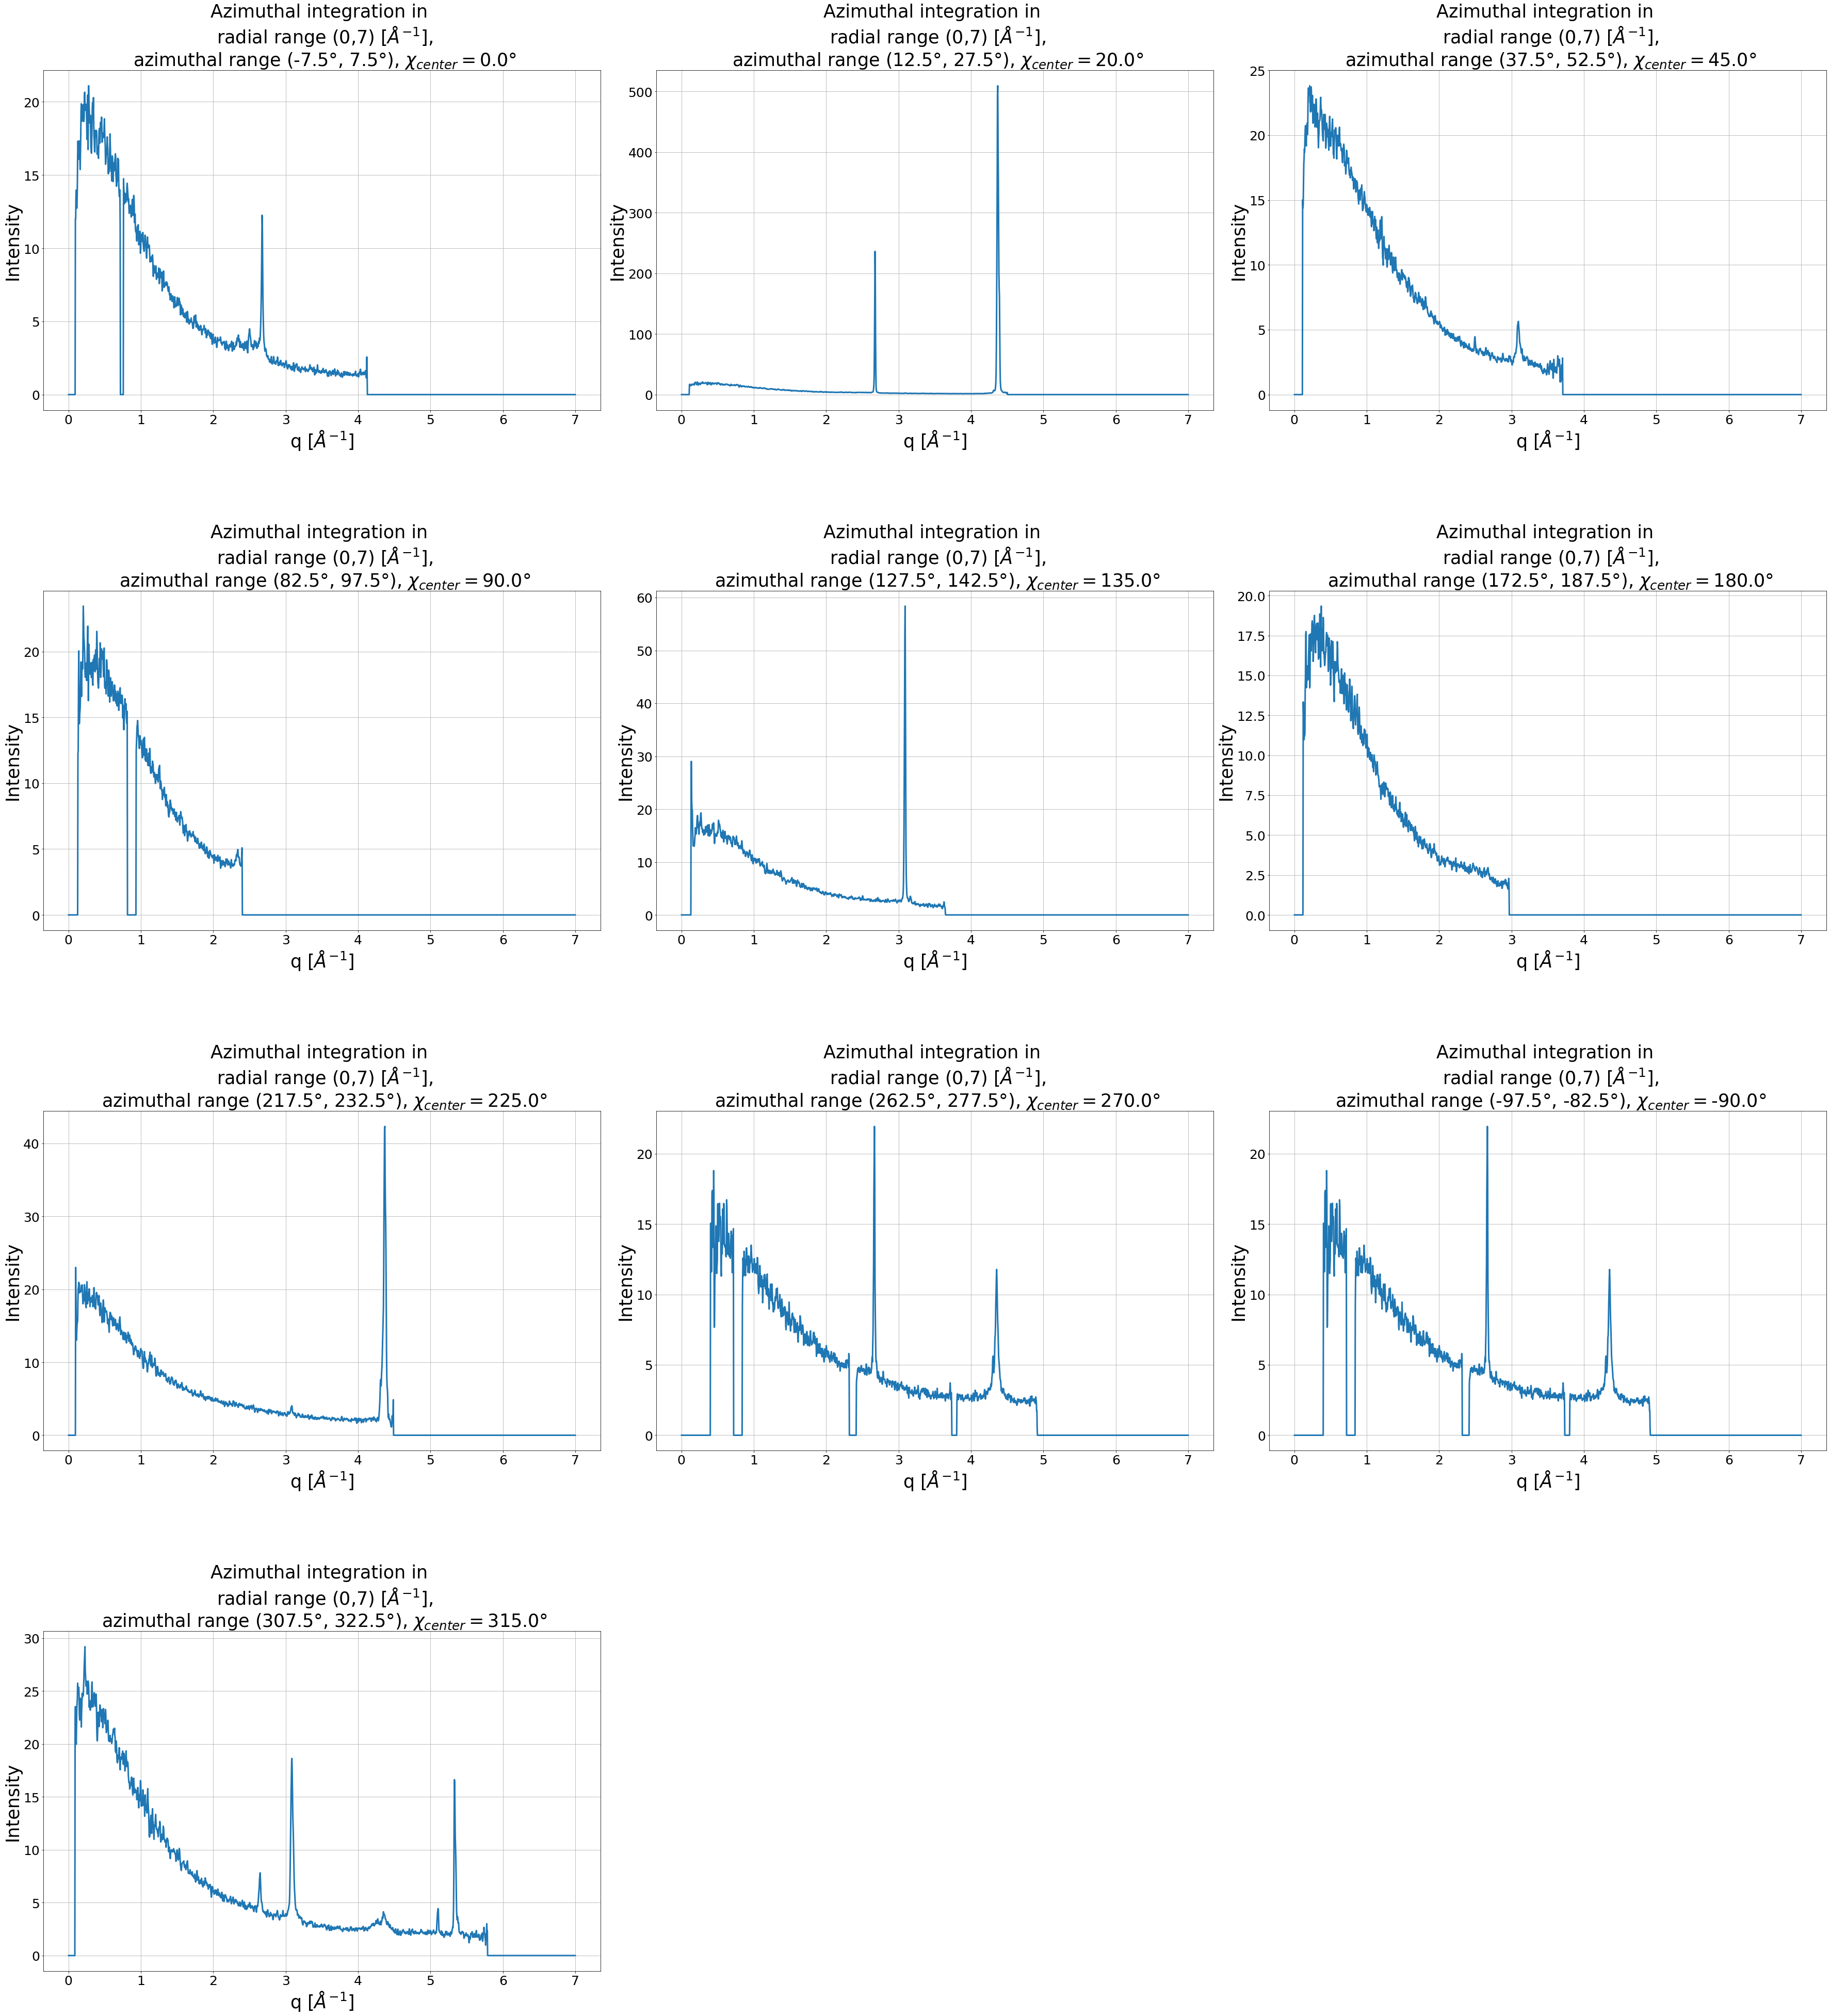

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(10, 1800)
(10, 1800)
True
Finished


In [37]:
# Setup a scan file
asdep_noload=PilatusData(source,output_path,poni_file=poni_file,mask_file=mask_file)

# Select one frame, here currently 2500
frame=2512
twod_image=asdep_noload.data_read(frame)


# Define q range, radial range
radial_range=(0,7) #q in Angström

# These are angles for the azimuthal integration
#azimuth_values=np.array([0,45,135,225,270,-90, 315]) 
azimuth_values=np.array([0,20,45,90,135,180,225,270,-90, 315])
#azimuth_values=np.array([0,22.5,45,90,135, 180,225,245, 270, 315, 337.5])
#azimuth_values=np.array([-115.20830359 , 138.12178433  , 25.97897445 , -49.08221011])


# 0.5 width of chi, chi=2*dchi in total
#dchi=7.5
dchi=7.5


# Prepare number of plots
# ( I need to write a nice plotting function for this.)
number_azimuth_values=len(azimuth_values)
rows = 4
cols = number_azimuth_values // rows + 1

def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

# Prepare the plot
figw,figh=50,50*1.0632008154943935
f, axs = plt.subplots(rows, cols,squeeze=True,figsize=(figw,figh))
# Adjust the subplots
plt.subplots_adjust(left=1/figw, right=1-1/figw, bottom=1/figh, top=1-1/figh,wspace=figw/500, hspace=figh/100)
font1=35

axs = trim_axs(axs, len(azimuth_values))


# Create an empty array
integration_array=np.zeros((len(azimuth_values),1800))
q_array=np.zeros((len(azimuth_values),1800))
sigma_array=np.zeros((len(azimuth_values),1800))


for ax,m, i in zip(axs, range(0,len(azimuth_values)), azimuth_values):
    
    # set azimuth_range for each iteration, azimuth angle in degrees
    azimuth_range=(i-dchi,i+dchi) 
    
   
    # Perform azimuthal integration
    azimuth_image=asdep_noload.data_integrate1d(twod_image,radial_range=radial_range,azimuth_range=azimuth_range)
    
    # Store result (integrated intensity) in the array
    integration_array[m,:]=azimuth_image[1]
    q_array[m,:]=azimuth_image[0]
    sigma_array[m,:]=azimuth_image[2]
    

    ax.plot(azimuth_image[0],azimuth_image[1], '-', linewidth=3, markersize=12)
        
    ax.set_title("Azimuthal integration in \n radial range (%d,%d) $[\AA^{-1}]$,\n azimuthal range (%.1f$\degree$, %.1f$\degree$), $\chi_{center}=$%.1f$\degree$" 
                 %(radial_range[0],radial_range[1], azimuth_range[0],azimuth_range[1],i),fontdict={'fontsize': font1})
   
    ax.tick_params(labelsize=25)
    ax.set_xlabel('q $[\AA^{-1}]$',fontdict={'fontsize':font1})
    ax.set_ylabel('Intensity',fontdict={'fontsize':font1})

    ax.grid(True) 
 
plt.show()

print(type(integration_array))
print(type(q_array))
print(integration_array.shape)
print(q_array.shape)


#Check if q_values are equal
print(np.array_equal(q_array[0,:],q_array[1,:]))


# save data
with h5py.File(output_path+'fit_example2.h5','w') as h5f:
    h5f.create_dataset("/entry/integ/q", data=q_array)
    h5f.create_dataset("/entry/integ/data", data=integration_array)
    h5f.create_dataset("/entry/integ/sigma", data=sigma_array)
    #h5f.create_dataset("/entry/integ/azimuth_range", data=azimuth_range)

print('Finished')


In [11]:
!pwd

/data/visitors/nanomax/20190570/2019052208/raw/Si_calibration_20190525


In [ ]:
help(asdep_noload.aipi.integrate1d)
#asdep_noload.aipi.integrate1d??
#help(asdep_noload.aipi.integrate2d)

# Test pyFAI and understand the azimuthal integration

981 1043
Corners azimuthal corrdinates:  [-118.54360716  141.35967999   28.35827387  -51.14713841]
Corners 2Theta corrdinates:  [38.65490038 26.00108902 32.45346811 41.82522508]
Indices where tth is minimum : (727, 395)
Fit2D centerX, centerY : (395.9070226199496, 727.4162157498703)
[  0.  15.  30.  45.  60.  75.  90. 105. 120. 135. 150. 165. 180. 195.
 210. 225. 240. 255. 270. 285. 300. 315. 330. 345.  nan]
0.0 -7.5 7.5 Number of pixels:  45514.00000147567
15.0 7.5 22.5 Number of pixels:  43480.99999841013
30.0 22.5 37.5 Number of pixels:  47164.99999635886
45.0 37.5 52.5 Number of pixels:  25965.000001428576
60.0 52.5 67.5 Number of pixels:  16576.000002429857
75.0 67.5 82.5 Number of pixels:  13232.00000153473
90.0 82.5 97.5 Number of pixels:  12898.999997904486
105.0 97.5 112.5 Number of pixels:  13853.999999773903
120.0 112.5 127.5 Number of pixels:  17323.000001009266
135.0 127.5 142.5 Number of pixels:  26093.999992174686
150.0 142.5 157.5 Number of pixels:  26068.999998788877
1

ValueError: cannot convert float NaN to integer

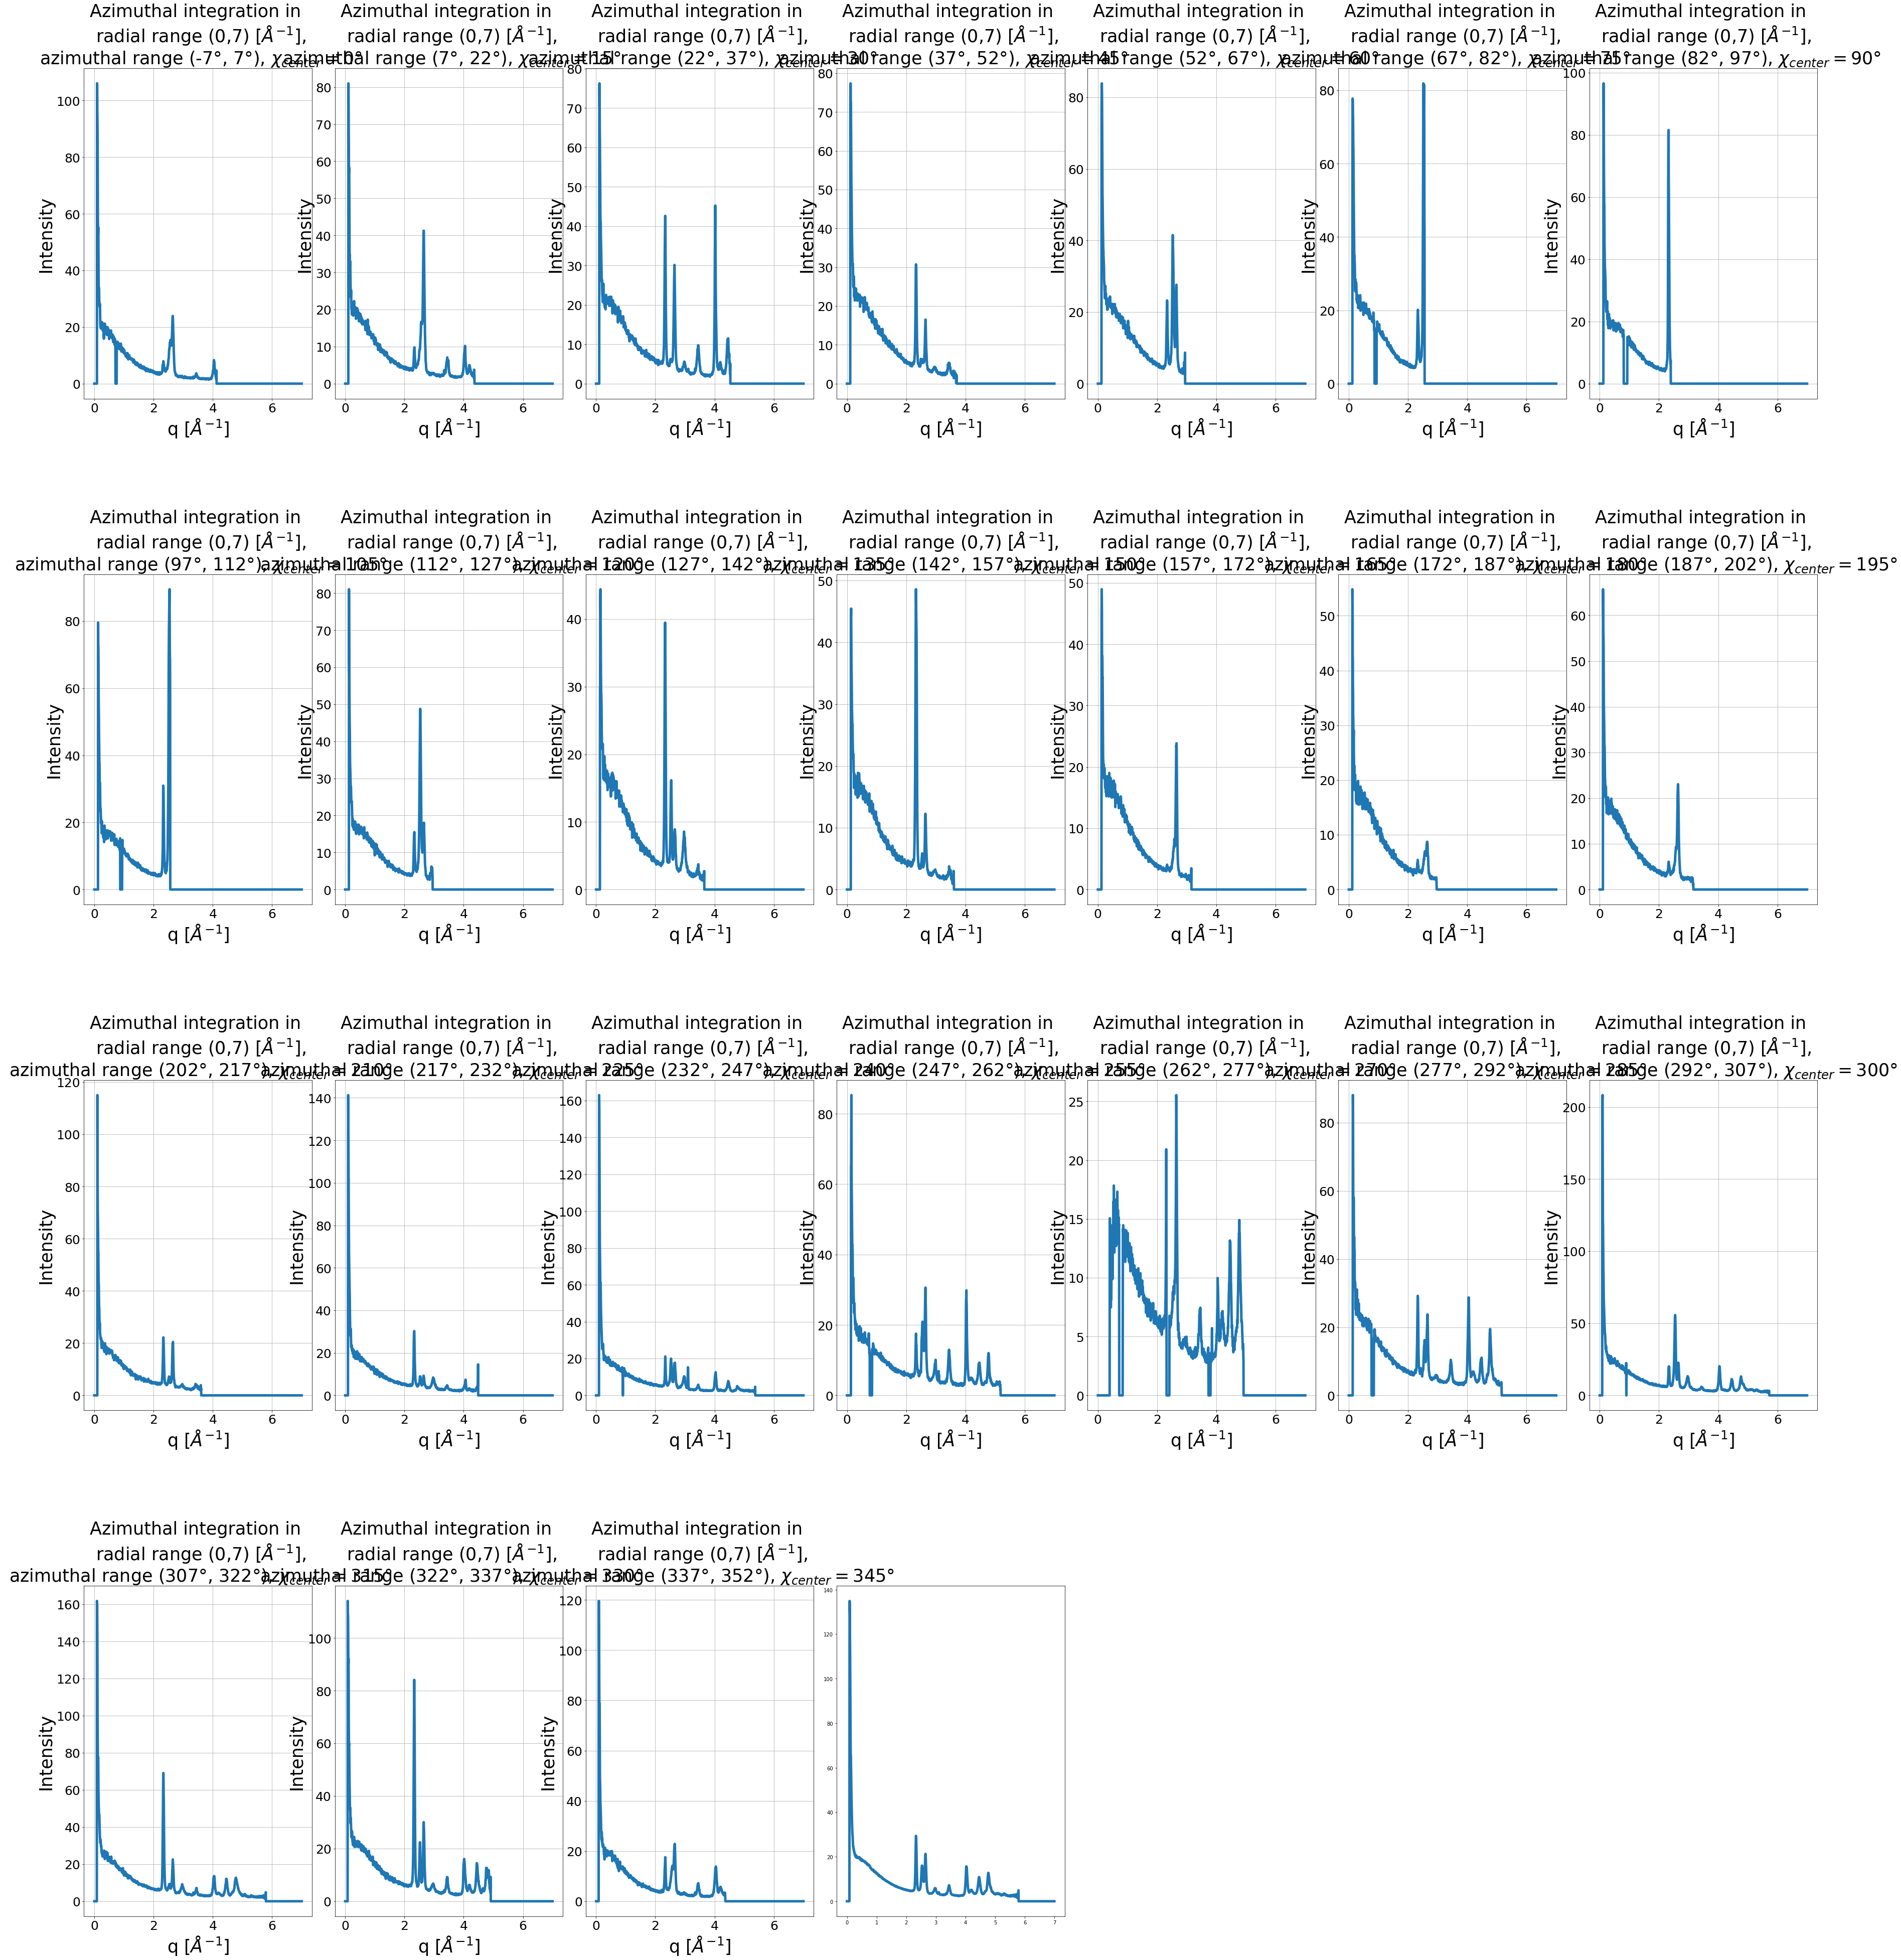

In [61]:
# Setup a scan file
asdep_noload=PilatusData(source,output_path,poni_file=poni_file,mask_file=mask_file)

# Select one frame, here currently 
#frame=2537
frame=2537
twod_image=asdep_noload.data_read(frame)

# Define q range, radial range
radial_range=(0,7) #q in Angström


print(twod_image.shape[1],twod_image.shape[0])

# auxlilary variables (chi and tth of detector pixels)
D2,D1 = np.meshgrid(np.arange(twod_image.shape[1]),np.arange(twod_image.shape[0]))
det_chi = asdep_noload.aipi.chi(D1,D2)*180./np.pi # rad
det_tth = asdep_noload.aipi.tth(D1,D2)*180./np.pi # rad

# create corner indices and calculate the chi and tth values for the corners
d2 = np.asarray([0,0,twod_image.shape[1],twod_image.shape[1]]) # x-coordinates of corners
d1 = np.asarray([0,twod_image.shape[0],twod_image.shape[0],0]) # y-coordinates of corners
print("Corners azimuthal corrdinates: ", asdep_noload.aipi.chi(d1,d2)*180./np.pi)
print("Corners 2Theta corrdinates: ", asdep_noload.aipi.tth(d1,d2)*180./np.pi)

# find the indices where tth is minimum (should correspond to the beam center)
minimum_tth_indices=np.unravel_index(np.argmin(det_tth), det_tth.shape)
print('Indices where tth is minimum :', minimum_tth_indices)


# create Fit2D geoemtry
pfit2D = asdep_noload.aipi.getFit2D()

##get center of image in pixel from Fit2D geoemetry
center=(pfit2D['centerX'],pfit2D['centerY'])
print('Fit2D centerX, centerY :', center)


#azimuth_values=np.array([0,90,180,275]) #four different quadrants
#azimuth_values=np.array(range(-90, 181, 45))    
#azimuth_values=np.array(range(0,360,int(sector_size)))

# these are the corners of one frame in chi
azimuth_values=np.array([-115.20830359,  138.12178433,   25.97897445,  -49.08221011])

# These are angles for the azimuthal integration
#azimuth_values=np.array([0,90,180,270,-90]) 


azimuth_values=np.array([0,45,90,135,180,225,270,-90, 315])
#azimuth_values=np.array([0,22.5,45,90,138,157.5, 180,225,270, 315, 337.5])
azimuth_values=np.array([0,22.5,45,90,135, 180,212,245, 265, 310, 337.5])

azimuth_values=np.array([  0,  15,  30,  45,  90, 140,180, 242,  270, 285, 300, 315, 330, 345])


x=np.array(np.linspace(0,360,25))
x[-1]=np.nan
azimuth_values=x
print(azimuth_values)

# Prepare dchi value
dchi=7.5


# Prepare number of plots
number_azimuth_values=len(azimuth_values)
rows = 4
cols = number_azimuth_values // rows + 1

def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

# Prepare the plot
figw,figh=50,50*1.0632008154943935
f, axs = plt.subplots(rows, cols,squeeze=True,figsize=(figw,figh))
# Adjust the subplots
plt.subplots_adjust(left=1/figw, right=1-1/figw, bottom=1/figh, top=1-1/figh,wspace=figw/500, hspace=figh/100)
font1=35

axs = trim_axs(axs, len(azimuth_values))

# Plot the different sectors

# Create an empty array
integration_array=np.zeros((len(azimuth_values),1800))


for ax,m, i in zip(axs, range(0,len(azimuth_values)), azimuth_values):
    
         
    # set azimuth_range for each iteration, azimuth angle in degrees
    azimuth_range=(i-dchi,i+dchi) 
    
    # Perform azimuthal integration
    azimuth_image=asdep_noload.data_integrate1d(twod_image,radial_range=radial_range,azimuth_range=azimuth_range)
    nb_pix=asdep_noload.data_integrate1d(twod_image,radial_range=radial_range,azimuth_range=azimuth_range).count.sum()
  
    print(i, i-dchi,i+dchi, 'Number of pixels: ',nb_pix)
    
    # Due to the discontinuity at pi. I change the location discontinuity.
    #if (azimuth_range[0]<180 and azimuth_range[1]>180):
    #    #asdep_noload.ai.setChiDiscAtZero() # change the location of the discontinuity
    #    
    #    azimuth_image=asdep_noload.data_integrate1d(twod_image,radial_range=radial_range,azimuth_range=azimuth_range)
    #    nb_pix=asdep_noload.data_integrate1d(twod_image,radial_range=radial_range,azimuth_range=azimuth_range).count.sum()
    #    
    #    #asdep_noload.ai.setChiDiscAtPi()   # back to standard
    #      
    #else:
    #    azimuth_image=asdep_noload.data_integrate1d(twod_image,radial_range=radial_range,azimuth_range=azimuth_range)
    
    #store intregrated values 
    integration_array[m,:]=azimuth_image[1]
    
    ax.plot(azimuth_image[0],azimuth_image[1],linewidth=5, markersize=15)
        
    ax.set_title("Azimuthal integration in \n radial range (%d,%d) $[\AA^{-1}]$,\n azimuthal range (%d$\degree$, %d$\degree$), $\chi_{center}=$%d$\degree$"
                   %(radial_range[0],radial_range[1], azimuth_range[0],azimuth_range[1],i),fontdict={'fontsize': font1})
   
    ax.tick_params(labelsize=25)
    ax.set_xlabel('q $[\AA^{-1}]$',fontdict={'fontsize':font1})
    ax.set_ylabel('Intensity',fontdict={'fontsize':font1})

    ax.grid(True) 
 
plt.show()

print(np.array_equal(integration_array[6,:],integration_array[7,:]))
plt.plot(integration_array[6,:]-integration_array[7,:])
plt.show()


print("Part 2")


from matplotlib.patches import Wedge

# Visualise the azimuth integration sectors
# plot this entry with matplotlib
twod_image=asdep_noload.data_read(frame)
fig2d, ax1  = plt.subplots(1,1,figsize=(10,10*1.0632008154943935))

im1=ax1.imshow(twod_image, norm=LogNorm(),cmap = 'inferno',origin="lower")
ax1.set_title('Origin=lower')


#create a colormap
cmap=plt.cm.get_cmap(plt.cm.viridis,143)
n=50

for k,i in enumerate(azimuth_values):
    chimin,chimax=(i-dchi,i+dchi) 
    print(i, chimin, chimax)
    ax1.add_patch(Wedge(center, 200, chimin, chimax, alpha=0.4, facecolor=cmap(n*k), edgecolor='w',label="%d, %d" % (chimin,chimax)))
    
    # select pixels only in integration range
    #Lind = np.logical_and(det_chi>=i-dchi,det_chi<=i+dchi)
    #timg = np.zeros(twod_image.shape,np.float)
    #timg[~Lind] = np.nan
    #timg[ Lind] = 1000
    #im1=ax1.imshow(timg, norm=LogNorm(), cmap = 'inferno',alpha=0.2, origin="lower")
    #im1=ax1.contour(timg, origin="lower")
    
    
    if (i-dchi<180 and i+dchi>180):
        #asdep_noload.aipi.setChiDiscAtZero()
        #det_chi = asdep_noload.ai0.chi(D1,D2)*180./np.pi # rad
        det_chi=asdep_noload.ai0.chiArray()*180/np.pi
        
        Lind = np.logical_and(det_chi>=i-dchi,det_chi<=i+dchi)
        timg = np.zeros(twod_image.shape,np.float)
        timg[~Lind] = np.nan
        timg[ Lind] = 1000
        
    else:
        #asdep_noload.ai.setChiDiscAtPi()
        #det_chi = asdep_noload.aipi.chi(D1,D2)*180./np.pi # rad
        det_chi=asdep_noload.aipi.chiArray()*180/np.pi
        Lind = np.logical_and(det_chi>=i-dchi,det_chi<=i+dchi)
        timg = np.zeros(twod_image.shape,np.float)
        timg[~Lind] = np.nan
        timg[ Lind] = 1000
        
    #print('ai.chi(), Current value of pixel (690,100)',det_chi2[690,100])
    #print('ai.chiArray(),Current value of pixel (690,100)',det_chi[690,100])
    im1=ax1.imshow(timg, norm=LogNorm(), cmap = 'inferno',alpha=0.2, origin="lower")
    im1=ax1.contour(timg, origin="lower")

      
min_d2, min_d1 = np.unravel_index(np.argmin(det_tth), det_tth.shape)
plt.plot(min_d1, min_d2, marker='x', color='r', markersize=10)
plt.plot(pfit2D['centerX'], pfit2D['centerY'], marker='+', color='b', markersize=10)

plt.legend()
plt.show()

!pwd
fig2d.savefig('with_ai.chiArray.png')







In [ ]:
#Play around with integrate2d
#res2d = ai.integrate2d(img, 300, 360, unit="2th_deg")
caked_image=asdep_noload.data_integrate2d(twod_image,npt_rad=3600)
#Example using pure matplotlib
I, tth, chi = caked_image
figcake=plt.figure(figsize=(6,6*1.0632008154943935))
plt.imshow(I, origin="lower", extent=[tth.min(), tth.max(), chi.min(), chi.max()], aspect="auto",norm=LogNorm(),cmap = 'inferno')
plt.xlabel("2 theta (deg)")
#plt.xlim([3,3.2])
plt.ylabel("Azimuthal angle chi (deg)")
plt.show()

In [ ]:
#As deposited
#TiAlN in the coating (4-7um), bonding layer TiN (1um+- few hundred nanomers 1.5-1.3um),base: WCCo (mixuture)
#fcc TiAlN , potentiall hexagonal TiAlN (in small quantities)

#1000 C
#TiAlN in the coating (4-7um), bonding layer TiN (1um+- few hundred nanomers 1.5-1.3um),base: WCCo (mixuture)
#but also cubic TiN and hexagonal AlN (2 phases in the sample) (maybe there is cubic AlN)
#16% Ti, 84% Al, 1:1:2 Ti:Al:N

## 

In [ ]:
d2 = np.asarray([0,0,twod_image.shape[1],twod_image.shape[1]]) # x-coordinates of corners
d1 = np.asarray([0,twod_image.shape[0],twod_image.shape[0],0]) # y-coordinates of corners
print("Corners azimuthal corrdinates: ", asdep_noload.ai.chi(d1,d2)*180./np.pi)
print("Corners 2Theta corrdinates: ", asdep_noload.ai.tth(d1,d2)*180./np.pi)


#asdep_noload.ai.setChiDiscAtPi??
#asdep_noload.ai.chi??
#asdep_noload.ai.integrate1d??

asdep_noload.ai.check_chi_disc??

asdep_noload.ai.setChiDiscAtPi()
det_chi=asdep_noload.ai.chiArray()*180/np.pi
det_chi2=asdep_noload.ai.chi(D1,D2)*180./np.pi
print(det_chi.ndim)
print('ChiDiscAtPi')
print(det_chi[690,100])
print(det_chi2[690,100])

asdep_noload.ai.setChiDiscAtZero()
det_chi=asdep_noload.ai.chiArray()*180/np.pi
det_chi2=asdep_noload.ai.chi(D1,D2)*180./np.pi
print('ChiDiscAtZero')
print(det_chi[690,100])
print(det_chi2[690,100])





In [ ]:
np.unravel_index(np.argmin(det_tth), det_tth.shape)


In [ ]:
#print(np.argmax(det_tth))

#Just playing around, this creates as well a Chi Array
aa=asdep_noload.ai.chiArray()*180/np.pi


print(d2,d1)
cx=pfit2D['centerX']
cy=pfit2D['centerY']
i=1
radius=np.sqrt((d2[i]-cx)**2+(d1[i]-cy)**2)
print(radius)

In [ ]:
pfit2D = asdep_noload.ai.getFit2D()
print(pfit2D)

In [ ]:
pfit2D['centerX']

In [ ]:
print(asdep_noload.ai0.check_chi_disc((0,180)))

In [ ]:
#Plot the mask data
plt.imshow(asdep_noload.mask_data,origin="lower")
plt.colorbar()
plt.show()

In [ ]:
a=list(lambda x: [i], range(0,7))
print(a)

In [ ]:
b=[1,2,3]
print(b.type())

## Plot azimuthal integration over 360º for one chosen frame

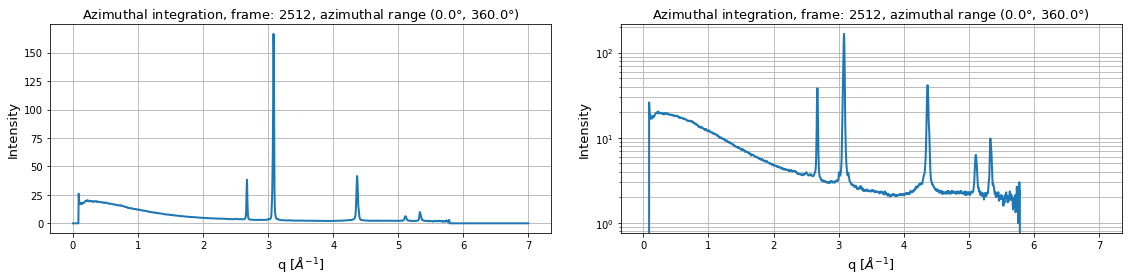

In [41]:
# Setup a scan file
asdep_noload=PilatusData(source,output_path,poni_file=poni_file,mask_file=mask_file)

# Select one frame, here currently 2500
#frame=2537
#frame=2520
#frame=2537
frame=2512

twod_image=asdep_noload.data_read(frame)

# Define q range, radial range
radial_range=(0,7) #q in Angström

# azimuth_range
azimuth_range=(0,360)


azimuth_image=asdep_noload.data_integrate1d(twod_image,radial_range=radial_range,azimuth_range=azimuth_range)

font1=13
plt.figure(figsize=(16, 4))
ax1=plt.subplot(121)
plt.plot(azimuth_image[0],azimuth_image[1],linewidth=2, markersize=10)
plt.xlabel('q $[\AA^{-1}]$',fontdict={'fontsize':font1})
plt.ylabel('Intensity',fontdict={'fontsize':font1})
plt.title('Azimuthal integration, frame: %d, azimuthal range (%.1f$\degree$, %.1f$\degree$)' 
                      %(frame, azimuth_range[0], azimuth_range[1]),fontdict={'fontsize': font1}) 
plt.grid(which='both',axis='both')

ax2=plt.subplot(122)
plt.semilogy(azimuth_image[0],azimuth_image[1],linewidth=2, markersize=10)
plt.xlabel('q $[\AA^{-1}]$',fontdict={'fontsize':font1})
plt.ylabel('Intensity',fontdict={'fontsize':font1})
plt.title('Azimuthal integration, frame: %d, azimuthal range (%.1f$\degree$, %.1f$\degree$)' 
                      %(frame, azimuth_range[0], azimuth_range[1]),fontdict={'fontsize': font1})
plt.grid(which='both',axis='both')
plt.tight_layout()
plt.show()


# save data
with h5py.File(output_path+'fit_example3.h5','w') as h5f:
    h5f.create_dataset("/entry/integ/q", data=[azimuth_image[0]])
    h5f.create_dataset("/entry/integ/data", data=[azimuth_image[1]])
    h5f.create_dataset("/entry/integ/sigma", data=[azimuth_image[2]])
    h5f.create_dataset("/entry/integ/azimuth_range", data=azimuth_range)

In [ ]:
#Plot the mask
plt.figure(figsize=(20,20))
plt.imshow(asdep_noload.mask_data)

In [40]:
for i in range(0,11):
    print(360/30*i)

0.0
12.0
24.0
36.0
48.0
60.0
72.0
84.0
96.0
108.0
120.0


In [14]:
360/15


24.0

In [19]:
x=np.linspace(0,360,25)
print(x)

[  0.  15.  30.  45.  60.  75.  90. 105. 120. 135. 150. 165. 180. 195.
 210. 225. 240. 255. 270. 285. 300. 315. 330. 345. 360.]


In [53]:
x=np.array(np.linspace(0,360,37))

print(x)


[  0.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100. 110. 120. 130.
 140. 150. 160. 170. 180. 190. 200. 210. 220. 230. 240. 250. 260. 270.
 280. 290. 300. 310. 320. 330. 340. 350. 360.]


In [55]:
x=np.array(np.linspace(0,360,37))
x[-1]=np.nan
print(x)

[  0.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100. 110. 120. 130.
 140. 150. 160. 170. 180. 190. 200. 210. 220. 230. 240. 250. 260. 270.
 280. 290. 300. 310. 320. 330. 340. 350.  nan]
